<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
# read in the data
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [4]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [19]:
def tokenize(doc):
    nlp_doc = nlp(doc.lower())
    doc_tokens = [token.text for token in nlp_doc 
                  if (token.is_stop==False) and (token.is_punct==False)
                  and token.pos_ != "-PRON-" and token.text != " "]
    return doc_tokens

In [20]:
tokenize(yelp['text'][0])

['beware',
 'fake',
 'fake',
 'fake',
 'small',
 'business',
 'los',
 'alamitos',
 'received',
 'looked',
 'like',
 'legitimate',
 'bill',
 '$',
 '70',
 'account',
 'number',
 'called',
 'phone',
 'number',
 'listed',
 '866',
 '273',
 '7934',
 'wait',
 'time',
 'hold',
 'said',
 '20',
 'minutes',
 'leave',
 'message',
 'live',
 'person',
 'phone',
 'matter',
 'number',
 'selected',
 'left',
 'firm',
 'message',
 'contacting',
 'bbb',
 'attorney',
 'company',
 'trying',
 'scam',
 'businesses',
 'illegal']

In [22]:
# apply tokenize() to create a series of tokenized texts
yelp['tokens'] = yelp['text'].apply(lambda x: tokenize(x))
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tokens
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[beware, fake, fake, fake, small, business, lo..."
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA,"[came, lunch, togo, service, quick, staff, fri..."
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA,"[vegas, dozens, times, stepped, foot, circus, ..."
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ,"[went, night, closed, street, party, best, act..."
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA,"[3.5, 4, stars, \n\n, bad, price, $, 12.99, lu..."


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=500)

In [43]:
sparse = tfidf.fit_transform(yelp['text'])
tf_yelp_df = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

In [44]:
tf_yelp_df.head()

,10,12,15,20,30,50,able,absolutely,actually,add,...,working,worst,worth,wouldn,wrong,year,years,yelp,yes,yummy
0,0.0,0.000000,0.000000,0.231025,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.137285,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.255808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.237569,0.212842,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [49]:
# instantiate 
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')

In [50]:
nn.fit(tf_yelp_df)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [51]:
nn.kneighbors([tf_yelp_df.iloc[0]])

(array([[0.        , 1.        , 1.        , 1.        , 1.        ,
         1.01818752, 1.05658108, 1.07694916, 1.10064376, 1.10453435]]),
 array([[   0,  469, 9889, 6204, 6311, 6899, 3714, 2131, 8470, 2865]]))

In [71]:
yelp['text'][9]

'Wow. I walked in and sat at the bar for 10 minutes. All the bartenders working and not one even said "Be right with you". And I was sitting next to the waitress station. The bartenders would chat with the waitresses and ignore me. I finally got a bartender\'s attention after about 15 minutes. Not that busy. I don\'t understand. I don\'t think I\'ll return. I\'ve been to many bars, many of the Stations casino\'s bars and I\'ve never seen service like this.'

In [83]:
fake_text = ['I walked in and sat at the bar for 20 minutes. No one came to take my order or get me a drink. The bartenders talked with the waitresses and ignored me. Will not be coming back.']

In [84]:
sparse_fake = tfidf.transform(fake_text)
fake = sparse_fake.todense()

In [85]:
nn.kneighbors(fake)

(array([[1.        , 1.        , 1.        , 1.        , 1.04583387,
         1.10102609, 1.10373202, 1.12869114, 1.12909893, 1.13077639]]),
 array([[9889,  469, 6204, 6311, 9336, 7900, 6914, 8554, 5213, 2659]]))

In [75]:
for num in [9889,  469, 6204, 6311, 9336, 7900, 6914, 8554, 5213, 2659]:
    print(yelp['text'][num])
    print('\n')

Bon massage.  Spa propre organisé manque juste le stationnement prix abordable en promotion personnels respectueux


O  o  thenk 6nnn  .b  cgv  xx TV cvg  9 nvehxcfvvv3c nb b  c  y4  nb and the vghvhridd h 0d  c       v   3,  vv  4  ruddy


旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。
質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 
ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。
予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。
また是非マッサージなどで伺いたいと思います。


天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來


I wish I could give this place negative stars...we got there around 5 sat down placed our drink and food order..and then we waited and waited for our food almost 30 minutes later we got our appetizers and wings. We then sat around for another 20 minutes waiting for a Togo box and then had to wait until a completely different waitress asked if we wanted our check. We walked out 10 minutes to 7...Our waiter was the worst waiter we have ever had

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [78]:
yelp.dtypes

business_id            object
cool                    int64
date           datetime64[ns]
funny                   int64
review_id              object
stars                   int64
text                   object
useful                  int64
user_id                object
tokens                 object
dtype: object

In [81]:
tfidf_vect = TfidfVectorizer(stop_words='english', max_features=1825, max_df=0.9)
mnb = MultinomialNB()

nb_pipe = Pipeline([('vect', tfidf_vect), ('clf', mnb)])

In [82]:
nb_pipe.fit(yelp['text'], yelp['stars'])

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1825, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [87]:
pred = nb_pipe.predict(fake_text)

In [88]:
pred

array([1])

#### Tune pipeline with grid search

In [115]:
from sklearn.model_selection import GridSearchCV

In [113]:
parameters = {
    'vect__max_df': (.6, .7, .8),
    'vect__min_df': (10, 20, 30),
    'vect__max_features': (500, 1000, 1500, 2000)
}

In [116]:
grid_search = GridSearchCV(nb_pipe, parameters, cv=5, n_jobs=-1, verbose=1)

In [120]:
grid_search.best_params_

{'vect__max_df': 0.6, 'vect__max_features': 2000, 'vect__min_df': 30}

In [121]:
grid_pred = grid_search.predict(fake_text)

In [122]:
grid_pred

array([1])

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

### Estimate LDA topic model

In [89]:
#imports
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
yelp['tokens'].head()

0    [beware, fake, fake, fake, small, business, lo...
1    [came, lunch, togo, service, quick, staff, fri...
2    [vegas, dozens, times, stepped, foot, circus, ...
3    [went, night, closed, street, party, best, act...
4    [3.5, 4, stars, \n\n, bad, price, $, 12.99, lu...
Name: tokens, dtype: object

In [96]:
# create a dictionary
id2word = corpora.Dictionary(yelp['tokens'])

In [98]:
# remove extreme values
id2word.filter_extremes(no_below=30, no_above=0.75)

In [99]:
# bag of words rep'n of corpus
corpus = [id2word.doc2bow(text) for text in yelp['tokens']]

In [112]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 15,
                   passes=10
                  )

Process ForkPoolWorker-58:
Process ForkPoolWorker-59:
Process ForkPoolWorker-60:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/Users/stephensinclair/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/Users/stephensinclair/anaconda3/envs/

### Visualizations

#### With 15 topics (initial number chosen arbitrarily)

In [101]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [102]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.167377 -0.019041       1        1  11.518357
3      0.165427 -0.102921       2        1  10.185817
9     -0.072565 -0.025382       3        1   9.575911
4     -0.019931 -0.042404       4        1   9.454995
14    -0.161496  0.070650       5        1   8.888716
12     0.169618  0.028237       6        1   8.816617
2     -0.110040 -0.077954       7        1   6.153473
6      0.151345  0.055864       8        1   6.114680
0     -0.018966 -0.043873       9        1   5.888827
5      0.089660 -0.075141      10        1   5.054668
1     -0.078336  0.186720      11        1   4.287158
11    -0.056678 -0.033874      12        1   3.726604
13     0.126197  0.144562      13        1   3.577847
10    -0.014009 -0.082594      14        1   3.527470
7     -0.002850  0.017150      15        1   3.228853, topic_info=     Category         Freq        Term        Total  loglift  logprob
268   Default  3004.000000          \n  3004.000000  30.0000  30.0000
120   Default  5019.000000        food  5019.000000  29.0000  29.0000
40    Default  8483.000000        \n\n  8483.000000  28.0000  28.0000
84    Default   956.000000        room   956.000000  27.0000  27.0000
171   Default  4292.000000       great  4292.000000  26.0000  26.0000
863   Default  1405.000000     chicken  1405.000000  25.0000  25.0000
601   Default   723.000000       store   723.000000  24.0000  24.0000
105   Default  4787.000000       place  4787.000000  23.0000  23.0000
0     Default  2278.000000           $  2278.000000  22.0000  22.0000
172   Default   387.000000        hair   387.000000  21.0000  21.0000
36    Default  3656.000000     service  3656.000000  20.0000  20.0000
1181  Default   445.000000       hotel   445.000000  19.0000  19.0000
97    Default  1787.000000        best  1787.000000  18.0000  18.0000
31    Default  4739.000000        good  4739.000000  17.0000  17.0000
286   Default  1234.000000   delicious  1234.000000  16.0000  16.0000
277   Default   814.000000      cheese   814.000000  15.0000  15.0000
586   Default   564.000000       sushi   564.000000  14.0000  14.0000
828   Default   636.000000      coffee   636.000000  13.0000  13.0000
854   Default  1557.000000     ordered  1557.000000  12.0000  12.0000
311   Default   811.000000       pizza   811.000000  11.0000  11.0000
547   Default  1684.000000        love  1684.000000  10.0000  10.0000
37    Default  1598.000000       staff  1598.000000   9.0000   9.0000
152   Default  1160.000000   recommend  1160.000000   8.0000   8.0000
159   Default  1339.000000     amazing  1339.000000   7.0000   7.0000
351   Default   870.000000    customer   870.000000   6.0000   6.0000
491   Default  1408.000000  restaurant  1408.000000   5.0000   5.0000
1283  Default   620.000000         car   620.000000   4.0000   4.0000
30    Default  1400.000000    friendly  1400.000000   3.0000   3.0000
411   Default   987.000000        told   987.000000   2.0000   2.0000
39    Default   353.000000         tea   353.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
898   Topic15    26.199465           +   149.807846   1.6894  -6.1958
603   Topic15    22.892262     toronto   130.222961   1.6946  -6.3308
1240  Topic15    39.969311        easy   259.824738   1.5611  -5.7735
435   Topic15    84.001801       super   700.870728   1.3116  -5.0307
73    Topic15   149.144638        nice  1699.316772   1.0000  -4.4567
37    Topic15   136.650909       staff  1598.657471   0.9736  -4.5441
398   Topic15    67.634781      prices   657.239258   1.1591  -5.2474
478   Topic15    38.018166   beautiful   284.236572   1.4213  -5.8235
30    Topic15   106.479965    friendly  1400.116943   0.8567  -4.7936
670   Topic15    68.429955       clean   705.940857   1.0993  -5.2358
31    Topic15   192.705673        good  4739.990723   0.2304  -4.2004
547   Topic15   104.104698   

In [107]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=yelp['tokens'], 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [108]:
# Thanks to Dwight, my screen no longer has 
import warnings
warnings.filterwarnings('ignore')

In [109]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

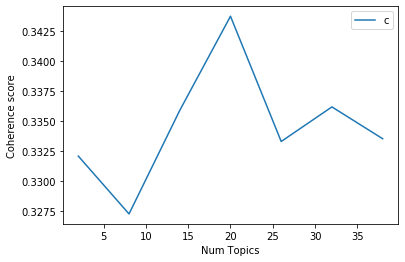

In [111]:
# Show graph
import matplotlib.pyplot as plt

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [129]:
lda.show_topics(num_topics=-1)

[(0,
  '0.037*"\n\n" + 0.019*"great" + 0.014*"place" + 0.012*"bar" + 0.011*"fun" + 0.011*"music" + 0.009*"like" + 0.008*"time" + 0.008*"night" + 0.008*"vegas"'),
 (1,
  '0.058*"food" + 0.036*"place" + 0.031*"great" + 0.027*"service" + 0.025*"best" + 0.017*"love" + 0.014*"good" + 0.012*"friendly" + 0.012*"vegas" + 0.011*"la"'),
 (2,
  '0.036*"\n\n" + 0.019*"good" + 0.014*"sushi" + 0.013*"tea" + 0.011*"$" + 0.009*"like" + 0.008*"order" + 0.007*"fish" + 0.007*"menu" + 0.006*"ordered"'),
 (3,
  '0.028*"$" + 0.018*"said" + 0.015*"\n\n" + 0.015*"told" + 0.011*"got" + 0.011*"asked" + 0.010*"service" + 0.010*"called" + 0.009*"went" + 0.009*"2"'),
 (4,
  '0.033*"food" + 0.016*"service" + 0.015*"time" + 0.014*"came" + 0.013*"\n\n" + 0.013*"ordered" + 0.011*"place" + 0.011*"table" + 0.011*"order" + 0.011*"server"'),
 (5,
  '0.038*"room" + 0.021*"hotel" + 0.021*"\n\n" + 0.012*"stay" + 0.011*"time" + 0.011*"like" + 0.010*"pool" + 0.009*"nice" + 0.009*"rooms" + 0.009*"vegas"'),
 (6,
  '0.022*"servic

In [142]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.show_topics(num_topics=-1)]
topics = [' '.join(t[0:5]) for t in words if t[0]!='a']

In [144]:
num = 1
for t in topics:
    print(str(num) + ": " + t)
    num += 1

1: 

 great place bar fun
2: food place great service best
3: 

 good sushi tea $
4: $ said 

 told got
5: food service time came 


6: room hotel 

 stay time
7: service great staff customer like
8: 
 

 good place great
9: good 

 pizza cheese place
10: 

 place good food like
11: 

 store coffee like great
12: chicken good food place ordered
13: 

 time work car day
14: hair great time salon amazing
15: food great good delicious place


### Analysis of topic model results

I ran a gensim estimation of a latent Dirichlet allocation in order to do topic modeling of the text of a subset of Yelp reviews. I chose 15 topics somewhat arbitrarily, as it seemed like an appropriate guess for the the number of topics.

Luckily, the model turned out fairly well for a first pass. The topics are relatively uniform in size, and are for the most part distinct.

There are some interesting overlaps, however. For instance car maitenence (6) seems to overlap with doctors and dentists (8). Although they provide different services, they are both skilled service providers, so it makes sense that some of the same words would belong to both topics. Additionally, there are some topics that are entirely or almost entirely subsets of other topics. For example, trendy bars with dancing (9) are entirely a subset of bars (4). And the words in greasy restaurant (12) are mostly a subset of the words in greasy restaurant with alcohol (3).

The model could be improved by increasing the number of passes in the LDA, fine tuning the number of categories, or adding additional pre-processing. A particularly annoying element of the data was the '\n' characters that the model continuously used, and which I did not have time to remove. There was also an issue with the KNN model where the model would continually predict review texts that were in languages other than English. Given more time to address these issues, the quality of the models would likely improve.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)